# Title : Predicting Visa Applications with Regression Algorithms

### Import necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

### Read dataset

In [2]:
df = pd.read_csv(r"C:\D3_Paper and online short term visa applications received by year and nationality.csv")
df.head(5)

,Nationality,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,128,127,178,58,67,189,220
1,Albania,409,528,521,109,159,571,396
2,Algeria,371,369,519,102,82,339,359
3,Angola,78,122,79,10,8,88,87
4,Armenia,174,164,270,41,27,241,244


## 1. Data characteristics

In [3]:
print("The size of the dataset is:",df.shape)
print("The dataset contains",df.shape[0],"rows")
print("The dataset contains",df.shape[1],"columns")

The size of the dataset is: (112, 8)
The dataset contains 112 rows
The dataset contains 8 columns


In [4]:
print("Names of attributes in the dataset are as follows :\n")
df.columns

Names of attributes in the dataset are as follows :



Index(['Nationality', '2017', '2018', '2019', '2020', '2021', '2022', '2023'], dtype='object')

In [5]:
print("Datatypes of the columns or attributes are as follows:\n")
df.dtypes

Datatypes of the columns or attributes are as follows:



Nationality    object
2017           object
2018           object
2019           object
2020           object
2021           object
2022           object
2023           object
dtype: object

#### Change Year column datatype to numeric

In [6]:
# List of year columns
year_columns = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']

# Convert year columns to integer type
df[year_columns] = df[year_columns].apply(pd.to_numeric, errors='coerce', axis=0)

df.dtypes

Nationality     object
2017           float64
2018           float64
2019           float64
2020           float64
2021           float64
2022           float64
2023           float64
dtype: object

In [7]:
## Check the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nationality  112 non-null    object 
 1   2017         106 non-null    float64
 2   2018         110 non-null    float64
 3   2019         108 non-null    float64
 4   2020         101 non-null    float64
 5   2021         96 non-null     float64
 6   2022         102 non-null    float64
 7   2023         104 non-null    float64
dtypes: float64(7), object(1)
memory usage: 7.1+ KB


In [8]:
num_countries = df['Nationality'].nunique()
print(f"There are {num_countries} unique countries in the Nationality column.")

There are 112 unique countries in the Nationality column.


#### Dataframe statistics

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
2017,106.0,964.018868,2667.584786,0.0,38.25,221.5,571.00,18570.0
2018,110.0,1041.545455,3032.142092,0.0,29.25,199.0,596.00,21831.0
2019,108.0,1146.916667,3486.589433,0.0,32.50,219.5,634.50,24305.0
2020,101.0,211.326733,630.351301,0.0,11.00,41.0,132.00,5190.0
2021,96.0,170.354167,476.553062,0.0,8.00,45.5,123.75,4173.0
2022,102.0,745.147059,2546.292791,0.0,51.25,205.0,569.00,24347.0
2023,104.0,716.846154,2766.740898,0.0,37.00,185.5,458.75,26364.0


## 2. Data Manipulation

 #### 2.1 (a) Check Missing Values

In [10]:
print("Check NULL or Missing values in the dataset. \n")
df.isnull().sum()

Check NULL or Missing values in the dataset. 



Nationality     0
2017            6
2018            2
2019            4
2020           11
2021           16
2022           10
2023            8
dtype: int64

In [11]:
# Remove rows with any NULL values
#df = df.dropna()

# Assuming 'df' is your DataFrame
df.fillna(0, inplace=True)

# Optionally, check if there are still any missing values
print("Checking for missing values after removal:")
print(df.isnull().sum())

Checking for missing values after removal:
Nationality    0
2017           0
2018           0
2019           0
2020           0
2021           0
2022           0
2023           0
dtype: int64


### 2.2 (a) Detect Outliers (IQR method)

Outliers detected using IQR method:
2017    15
2018    14
2019    14
2020    13
2021    12
2022     9
2023     9
dtype: int64


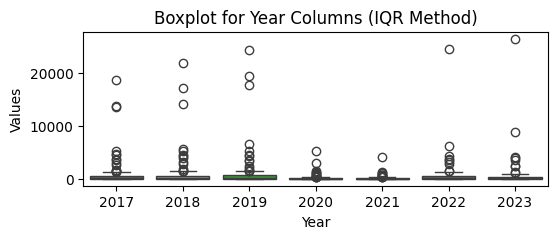

In [12]:
# Calculate IQR for each year column
Q1 = df[year_columns].quantile(0.25)
Q3 = df[year_columns].quantile(0.75)
IQR = Q3 - Q1

# Detect outliers: values outside of the range (Q1 - 1.5*IQR) and (Q3 + 1.5*IQR)
outliers_iqr = ((df[year_columns] < (Q1 - 1.5 * IQR)) | (df[year_columns] > (Q3 + 1.5 * IQR))).sum()

print("Outliers detected using IQR method:")
print(outliers_iqr)  

plt.figure(figsize=(6, 2))
sns.boxplot(data=df[year_columns])
plt.title("Boxplot for Year Columns (IQR Method)")
plt.xlabel("Year")
plt.ylabel("Values")
plt.show()

### 2.2 (b) Handle Outliers (Replace outliers with a median value)

Data shape after treating the outliers using IQR: (112, 8)


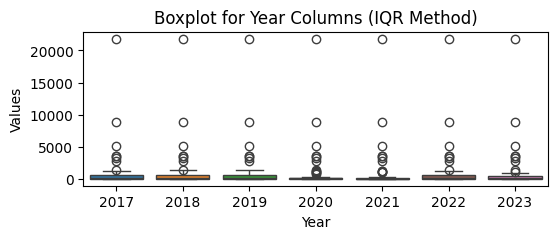

In [13]:
# Calculate IQR for each year column
Q1 = df[year_columns].quantile(0.25)
Q3 = df[year_columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers (values outside the range)
outliers_iqr = ((df[year_columns] < (Q1 - 1.5 * IQR)) | (df[year_columns] > (Q3 + 1.5 * IQR)))

# Replace outliers with the median of the respective row
df[year_columns] = df[year_columns].apply(
    lambda row: row.where(~outliers_iqr.loc[row.name], row.median(axis=0)), axis=1
)

# Verify the shape of the new DataFrame
print(f"Data shape after treating the outliers using IQR: {df.shape}")

plt.figure(figsize=(6, 2))
sns.boxplot(data=df[year_columns])
plt.title("Boxplot for Year Columns (IQR Method)")
plt.xlabel("Year")
plt.ylabel("Values")
plt.show()


## 3. Data Visualization

#### Univariate Analysis : 1. Plot frequency distribution for each column using Violine Chart

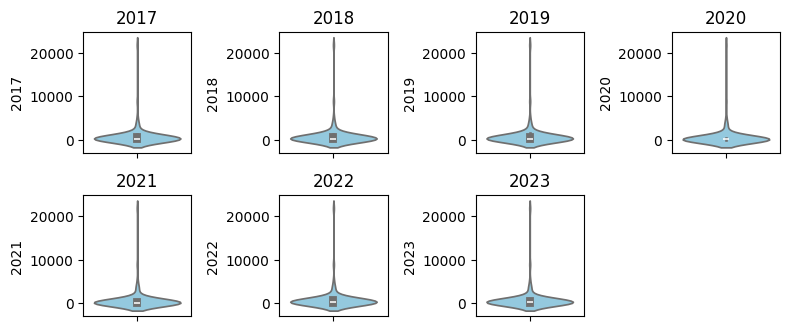

In [14]:
# Create violin plots for each numeric column
plt.figure(figsize=(8, 5))
for i, column in enumerate(df.select_dtypes(include=['float64']).columns, 1):
    plt.subplot(3, 4, i)  # Adjust rows/columns based on the number of plots
    sns.violinplot(y=df[column], color='skyblue')  # Use color instead of palette
    plt.title(f"{column}")

plt.tight_layout()
plt.show()

#### Univariate Analysis : 2. Plot frequency distribution for each column using Kernel Density Plot

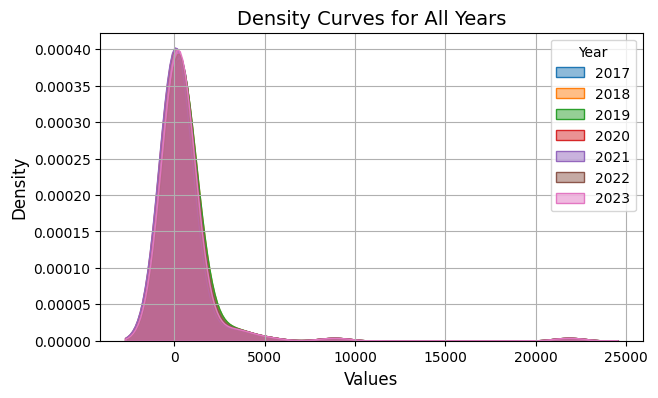

In [15]:
# Set the figure size
plt.figure(figsize=(7,4))

# Loop through each numeric column and plot its KDE
for column in df.select_dtypes(include=['float64']).columns:
    sns.kdeplot(df[column], fill=True, label=column, alpha=0.5)

# Customize the plot
plt.title("Density Curves for All Years", fontsize=14)
plt.xlabel("Values", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Year")
plt.grid(True)
plt.show()

#### Bivariate Analysis : 1. Get top 10 countries with highest total population

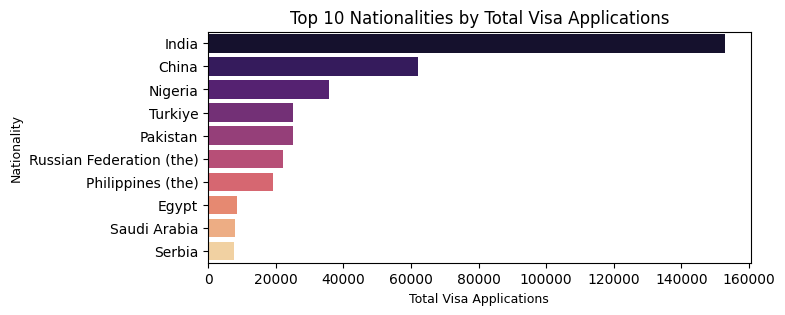

In [16]:
## Create a copy of df
df1=df.copy()

# List of year columns
year_columns = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']

# Create total visa applications column
df1['Total_Visa_Applications'] = df1[year_columns].sum(axis=1)

top_10_df = df1.nlargest(10, 'Total_Visa_Applications')

# Plot the bar chart for top 10 nationalities
plt.figure(figsize=(7,3))
sns.barplot(x='Total_Visa_Applications', y='Nationality', data=top_10_df, palette='magma', hue = 'Nationality')

# Add title and labels
plt.title('Top 10 Nationalities by Total Visa Applications', fontsize=12)
plt.xlabel('Total Visa Applications', fontsize=9)
plt.ylabel('Nationality', fontsize=9)

# Display the plot
plt.show()


#### Bivariate Analysis : 2. Get bottom 10 countries with lowest total population

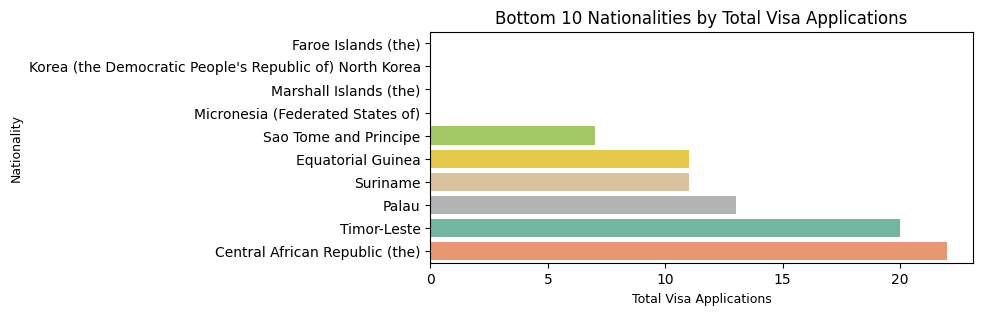

In [17]:
## Get bottom 10 natioanlities 
bottom_10_df = df1.nsmallest(10, 'Total_Visa_Applications')

# Plot the bar chart for bottom 10 nationalities
plt.figure(figsize=(7,3))
sns.barplot(x='Total_Visa_Applications', y='Nationality', data=bottom_10_df, palette='Set2', hue = 'Nationality')

# Add title and labels
plt.title('Bottom 10 Nationalities by Total Visa Applications', fontsize=12)
plt.xlabel('Total Visa Applications', fontsize=9)
plt.ylabel('Nationality', fontsize=9)

# Display the plot
plt.show()


#### Multivariate Analysis : 1. Overall population trend from 2017 to 2023

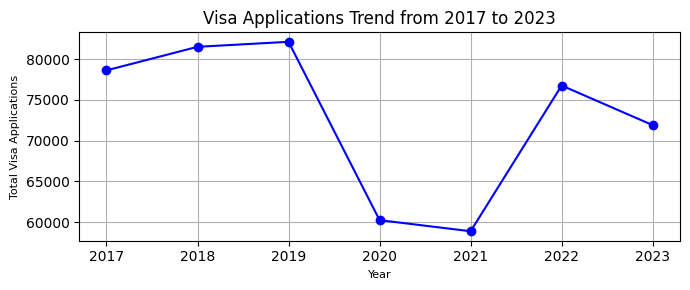

In [18]:
## Create a copy of df
df1=df.copy()

# year columns
year_columns = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']

# Create total visa applications column
df1['Total_Visa_Applications'] = df1[year_columns].sum(axis=1)

# Sum the visa applications for each year across all countries
total_visa_applications_per_year = df1[year_columns].sum()

# Plot the trend of visa applications over the years
plt.figure(figsize=(7,3))

# Plot the line graph
plt.plot(total_visa_applications_per_year.index, total_visa_applications_per_year.values, marker='o', linestyle='-', color='b')

# Add titles and labels
plt.title('Visa Applications Trend from 2017 to 2023', fontsize=12)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Total Visa Applications', fontsize=8)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


#### Multivariate Analysis : 2. Heatmap 

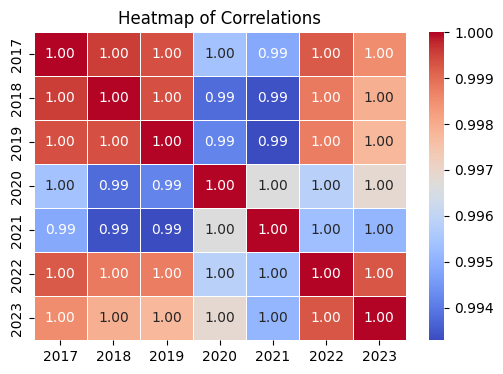

In [19]:
# correlation matrix for numerical columns
correlation_matrix = df.select_dtypes(include=['float64']).corr()

# Plot the heatmap
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Heatmap of Correlations")
plt.show()

## 4. Regression Modelling and Error Prediction

#### We applied Linear regression, RandomForest Regressor, SVM and Gradient Boosting Regressor algorithm to train the dataset.

#### Important Steps Applied 
     1. Log Transformation (To make the ditribution normal)
     2. Train-Test Split and StandardScaling
     3. K-Fold Cross Validation
     4. Error Functions Used : MSE, RMSE, MAE, R2
     5. Best Model Selection/ Linea Regressor  - Actual Vs Predicted Comparision for first 10 rows
     6. Plotting graphs for the best model (Actual Vs Predicted, Residual Error)




The chart showing MSE,RMSE, MAE and R-Squared values for all the regression models:



,Model,MSE,RMSE,MAE,R²
0,Linear Regression,0.1458,0.3818,0.2649,0.9717
1,Random Forest Regressor,0.2138,0.4624,0.3142,0.9586
2,Support Vector Regressor (SVM),0.2300,0.4796,0.3315,0.9554
3,Gradient Boosting Regressor,0.2380,0.4879,0.3285,0.9539



The sample first 10 rows showing Actual Vs Predicted comparison for the best model - Linear Regression:



,Actual/Ground Truth/(2023),Predicted value(2023) by Linear Regressor
0,2.833213,2.793644
1,5.545177,5.296836
2,5.501258,5.161758
3,5.579730,5.523104
4,6.508769,6.570430
5,3.951244,4.109584
6,1.791759,2.066545
7,5.575949,5.769106
8,0.000000,0.603916
9,5.749393,5.738046



Below are 2 graphs 1.Actual vs Predicted for Linear Regressor and 2.Residual Plot for Linear Regression Regressor



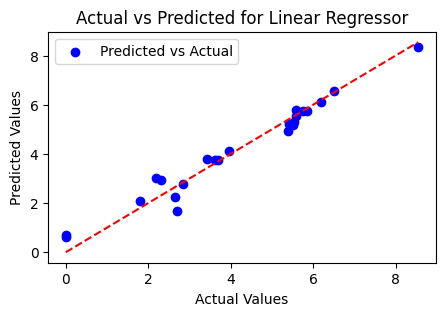

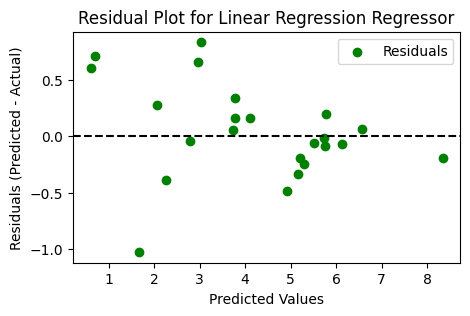

In [20]:
# cross-validation function
def evaluate_model_cv(model, X, y, model_name, cv_folds=20):
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X, y, cv=kf)
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return {
        "Model": model_name,
        "MSE": round(mse, 4),
        "RMSE": round(rmse, 4),
        "MAE": round(mae, 4),
        "R²": round(r2, 4)
    }


# Separating year columns
year_columns = ['2017', '2018', '2019', '2020', '2021', '2022', '2023']

# Apply log transformation to all year columns (2017-2023) to make the ditribution normal
df.loc[:, year_columns] = df[year_columns].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0)

# Separate features (X) and target (y)
X = df[year_columns[:-1]]  # Features: 2017-2022
y = df[year_columns[-1]]   # Target: 2023

# Use standard scaling on features (2017-2022)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Evaluations Logic
metrics = []

# 1. Linear Regression
lr_model = LinearRegression()
metrics.append(evaluate_model_cv(lr_model, X_train, y_train, "Linear Regression"))

# 2. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
metrics.append(evaluate_model_cv(rf_model, X_train, y_train, "Random Forest Regressor"))

# 3. Support Vector Regressor (SVM)
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
metrics.append(evaluate_model_cv(svr_model, X_train, y_train, "Support Vector Regressor (SVM)"))

# 4. Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
metrics.append(evaluate_model_cv(gbr_model, X_train, y_train, "Gradient Boosting Regressor"))

# Show metrics in dataframe
metrics_df = pd.DataFrame(metrics)

# Display the table
print("\nThe chart showing MSE,RMSE, MAE and R-Squared values for all the regression models:\n")
display(metrics_df)

# Select Linear Regressor for comparison and plotting the graphs
# Train the Linear Regressor model on the full training set
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)


# Run a comparison on Actual Vs Predicted for first 10 rows 
comparison = pd.DataFrame({
    "Actual/Ground Truth/(2023)": y_test.head(10).values,
    "Predicted value(2023) by Linear Regressor": lr_pred[:10]
})


print("\nThe sample first 10 rows showing Actual Vs Predicted comparison for the best model - Linear Regression:\n")
# Display the comparison
display(comparison)

print("\nBelow are 2 graphs 1.Actual vs Predicted for Linear Regressor and 2.Residual Plot for Linear Regression Regressor\n")


# Plot Actual vs Predicted values for Linear Regression
plt.figure(figsize=(5, 3))
plt.scatter(y_test, lr_pred, color='blue', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Line of perfect prediction
plt.title('Actual vs Predicted for Linear Regressor')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Plot Residuals (Error) for Linear Regressor
residuals = lr_pred - y_test

plt.figure(figsize=(5, 3))
plt.scatter(lr_pred, residuals, color='green', label='Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residual Plot for Linear Regression Regressor')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Predicted - Actual)')
plt.legend()
plt.show()
